In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys
import bpy

sys.path.append(str(Path("..").resolve()))
from src import *

In [18]:
dataset = ObjaverseDataset3D()
dataset.statistics.sample(n=20)

,meshCount,uvCount,diffuseCount,uvScore,valid
uid,,,,,
ba38bce2d06748209b1a3274ab628f50,1,0,0,<NA>,False
843ca5e830ae45fead6944d11d20243b,1,0,0,<NA>,False
9b75bbf92f414a17b4e932e866b1f6fa,16,<NA>,<NA>,<NA>,<NA>
0bbb3870cafe4c5aa5bd307198a75b06,1,1,1,0.581394,False
af6b38c0ad7b4d13b965ba829fc1aa50,3,<NA>,<NA>,<NA>,<NA>
11c976d9fd9d493e85e5f33699894bb7,1,1,0,0.360341,False
567bf7b6e874403390adad0ecccbe4dd,1,1,0,0.498175,False
ae56922235964bdc9ce8f2b6747b4eb5,2,<NA>,<NA>,<NA>,<NA>
288b365db9934bf9a69dd851d67ca392,1,1,1,0.461429,False


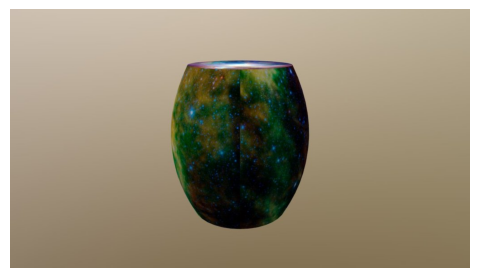

Found 1 materials, 1 UV-maps, 1 diffuse in 1 objects


In [48]:
UID = "5737eb3b46784c8b81938aa1c99228b6"
imshow((obj3d:=dataset[UID]).renderings, size=6)
processor = Processor(obj3d)
processor.analyze_scene()

In [49]:
processor.group_meshes()
processor.analyze_scene()

Joined () objects from () materials
Found 1 materials, 1 UV-maps, 1 diffuse in 1 objects


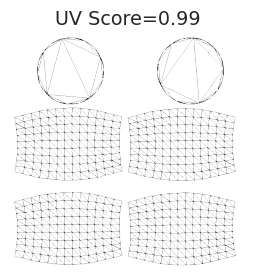

In [50]:
imshow({f"UV Score={obj3d.uv_score(bpy.data.objects[i].data):.2f}": uv for i, uv in enumerate(processor.uvs(pil=True))})

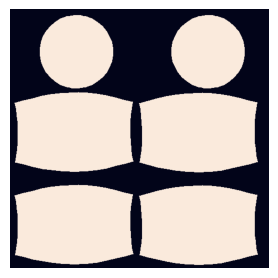

In [51]:
imshow(processor.masks())

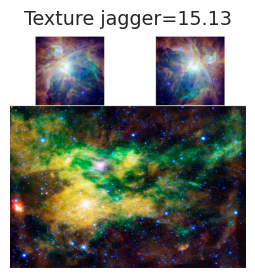

In [52]:
filter = LaplacianFilter()
imshow({f"Texture jagger={filter(diff)[0]:.2f}": diff for diff in processor.diffuses(pil=True)})